In [1]:
import os
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


# Define a function to parse a single JSON file
def parse_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    playlists = data.get('playlists', [])
    records = []
    for playlist in playlists:
        pid = playlist.get('pid', None)  # Default to None if 'pid' is missing
        playlist_name = playlist.get('name', 'Unknown')  # Default to 'Unknown' if 'name' is missing
        
        # Check if 'tracks' exists and is a list
        if not isinstance(playlist.get('tracks'), list):
            continue  # Skip this playlist if 'tracks' is missing or not a list
        
        for track in playlist['tracks']:
            # Skip the track if any required field is missing or invalid
            if not track.get('track_uri') or not track.get('track_name'):
                continue
            
            # Add the valid track record
            records.append({
                'pid': pid,
                'playlist_name': playlist_name,
                'track_name': track.get('track_name', 'Unknown'),
                'artist_name': track.get('artist_name', 'Unknown'),
                'album_name': track.get('album_name', 'Unknown'),
                'duration_ms': track.get('duration_ms', 0),
                'track_uri': track.get('track_uri', 'Unknown')
            })
    return records


# Load all JSON files in a directory
def load_data_from_directory(directory_path):
    all_records = []
    for file_name in os.listdir(directory_path):
        if file_name.endswith('.json'):
            file_path = os.path.join(directory_path, file_name)
            print(f"Processing file: {file_name}")  # Print statement to check the file being processed
            try:
                records = parse_json(file_path)
                print(f"Records added from {file_name}: {len(records)}")  # Print the number of records added
                all_records.extend(records)
            except Exception as e:
                print(f"Error processing file {file_name}: {e}")  # Log the error
    return pd.DataFrame(all_records)


# Load the data
directory_path = '/Users/wook/Documents/Github/MusicRecommendationSystem_Using_Deeplearning/Data/spotify_million_playlist_dataset_challenge'  # Update with your directory
df = load_data_from_directory(directory_path)

# Print final DataFrame info and preview
print(f"Total records loaded: {len(df)}")  # Print the total number of records
print(df.head())  # Print the first few rows of the DataFrame


Processing file: challenge_set.json
Records added from challenge_set.json: 281000
Total records loaded: 281000
       pid playlist_name                                         track_name  \
0  1000000         Party                                       Little Swing   
1  1000000         Party                                   I'm an Albatraoz   
2  1000000         Party  Yellow Flicker Beat - From The Hunger Games: M...   
3  1000000         Party                                  White Teeth Teens   
4  1000000         Party                                               Team   

  artist_name           album_name  duration_ms  \
0   AronChupa         Little Swing       163809   
1   AronChupa     I'm an Albatraoz       166848   
2       Lorde  Yellow Flicker Beat       232506   
3       Lorde         Pure Heroine       216600   
4       Lorde         Pure Heroine       193058   

                              track_uri  
0  spotify:track:66U0ASk1VHZsqIkpMjKX3B  
1  spotify:track:5MhsZl

In [2]:
from sklearn.preprocessing import MinMaxScaler

# Generate TF-IDF vectors for text features
def generate_tfidf_features(df, column):
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df[column].fillna(''))
    return tfidf_matrix, tfidf

# Normalize numerical features
def normalize_numeric_feature(df, column):
    scaler = MinMaxScaler()
    normalized = scaler.fit_transform(df[[column]].fillna(0))
    return normalized, scaler

# Apply TF-IDF and normalization
tfidf_track_name, track_name_vectorizer = generate_tfidf_features(df, 'track_name')
tfidf_artist_name, artist_name_vectorizer = generate_tfidf_features(df, 'artist_name')
tfidf_album_name, album_name_vectorizer = generate_tfidf_features(df, 'album_name')
duration_normalized, duration_scaler = normalize_numeric_feature(df, 'duration_ms')


In [3]:
from scipy.sparse import hstack

# Combine all features into one matrix
combined_features = hstack([tfidf_track_name, tfidf_artist_name, tfidf_album_name, duration_normalized])


In [4]:
from scipy.sparse import csr_matrix

def recommend_tracks(input_track_name, df, combined_features, top_n=10):
    # Find the index of the input track
    try:
        input_idx = df[df['track_name'].str.contains(input_track_name, case=False, na=False)].index[0]
    except IndexError:
        raise ValueError(f"Track '{input_track_name}' not found in the dataset.")

    # Convert sparse matrix to a compressed sparse row (CSR) format for row slicing
    if not isinstance(combined_features, csr_matrix):
        combined_features = csr_matrix(combined_features)
    
    # Calculate cosine similarity
    input_vector = combined_features[input_idx]  # Get the feature vector of the input track
    similarity = cosine_similarity(input_vector, combined_features).flatten()  # Calculate similarities

    # Get top N similar tracks
    top_indices = similarity.argsort()[-top_n-1:-1][::-1]  # Exclude the input track itself
    return df.iloc[top_indices]

# Example: Recommend tracks similar to "love"
try:
    recommended_tracks = recommend_tracks("love", df, combined_features)
    print(recommended_tracks)
except ValueError as e:
    print(e)


            pid playlist_name                                track_name  \
6775    1004846       Unknown                              In This Love   
93118   1016675    Good vibes                              In This Love   
190295  1033675    good vibes         Smokin' Love (feat. Collie Buddz)   
93155   1016675    Good vibes         Smokin' Love (feat. Collie Buddz)   
93133   1016675    Good vibes                       Fire on the Horizon   
190294  1033675    good vibes                          Sound of the Sea   
93197   1016675    Good vibes                          Sound of the Sea   
24      1000040           bbq                          Sound of the Sea   
23      1000040           bbq  Choice Is Yours (feat. Slightly Stoopid)   
55186   1007211       Cruisin  Choice Is Yours (feat. Slightly Stoopid)   

         artist_name    album_name  duration_ms  \
6775    Stick Figure  Set in Stone       252693   
93118   Stick Figure  Set in Stone       252693   
190295  Stick Figure 

In [6]:
import numpy as np
import pandas as pd

def create_training_data_optimized(df, max_pairs_per_playlist=100, max_negative_samples=None):
    positive_samples = []
    negative_samples = []

    # Positive pairs with limited sampling
    for pid, group in df.groupby('pid'):
        tracks = group['track_uri'].tolist()
        
        # Generate all possible pairs
        if len(tracks) > 1:
            pairs = np.array(np.triu_indices(len(tracks), k=1)).T
            np.random.shuffle(pairs)  # Randomize the pairs
            
            # Limit to max pairs per playlist
            if len(pairs) > max_pairs_per_playlist:
                pairs = pairs[:max_pairs_per_playlist]

            positive_samples.extend([(tracks[p[0]], tracks[p[1]], 1) for p in pairs])

    # Create a single array of all unique tracks
    all_tracks = df['track_uri'].unique()
    num_positive_samples = len(positive_samples)
    num_negative_samples = max_negative_samples if max_negative_samples else num_positive_samples

    # Generate negative pairs via efficient random sampling
    negative_samples = [
        (all_tracks[i], all_tracks[j], 0)
        for i, j in zip(
            np.random.randint(0, len(all_tracks), num_negative_samples),
            np.random.randint(0, len(all_tracks), num_negative_samples),
        )
        if i != j  # Ensure the pair isn't the same track
    ]

    # Combine positive and negative samples
    samples = positive_samples + negative_samples
    return pd.DataFrame(samples, columns=['track1', 'track2', 'label'])

# Call the function with a DataFrame
samples_df = create_training_data_optimized(df, max_pairs_per_playlist=100, max_negative_samples=50000)


In [7]:
# Create Feature Matrix
def create_feature_matrix(df, tfidf_vectorizer):
    track_features = {}
    metadata = df[['track_uri', 'track_name', 'artist_name', 'album_name', 'duration_ms']]

    tfidf_matrix = tfidf_vectorizer.fit_transform(metadata['track_name'].fillna(''))
    for i, row in metadata.iterrows():
        track_features[row['track_uri']] = np.concatenate([
            tfidf_matrix[i].toarray().flatten(),
            [row['duration_ms'] / 100000]
        ])
    return track_features

tfidf_vectorizer = TfidfVectorizer(max_features=100)
track_features = create_feature_matrix(df, tfidf_vectorizer)



In [8]:
def generate_features(samples_df, track_features):
    features = []
    for _, row in samples_df.iterrows():
        track1_features = track_features.get(row['track1'], np.zeros(101))
        track2_features = track_features.get(row['track2'], np.zeros(101))
        features.append(np.concatenate([track1_features, track2_features]))
    return np.array(features)

X = generate_features(samples_df, track_features)
y = samples_df['label']

Random Forest Accuracy: 0.9105803571428571


Text(0.5, 1.0, 'Confusion Matrix - Random Forest')

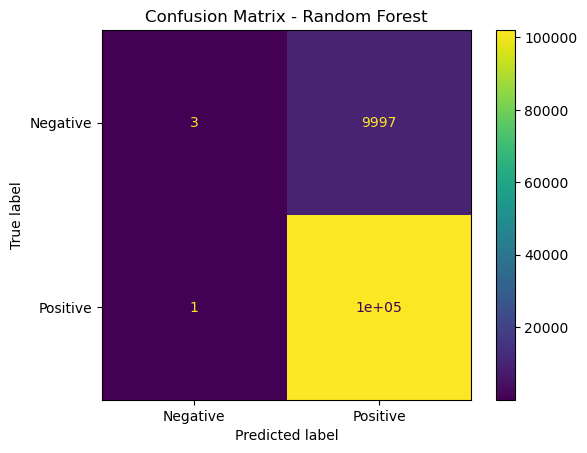

In [44]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Dimensionality reduction
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X)

# Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_reduced, y, test_size=0.2, random_state=42, stratify=y
)

# Train the model with parallelization
rf_model = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy_rf}")
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["Negative", "Positive"])
disp_rf.plot()
disp_rf.ax_.set_title("Confusion Matrix - Random Forest")

/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning: [21:13:18] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Xgboost_Accuracy: 0.9107946428571428


Text(0.5, 1.0, 'Confusion Matrix - XGBoost')

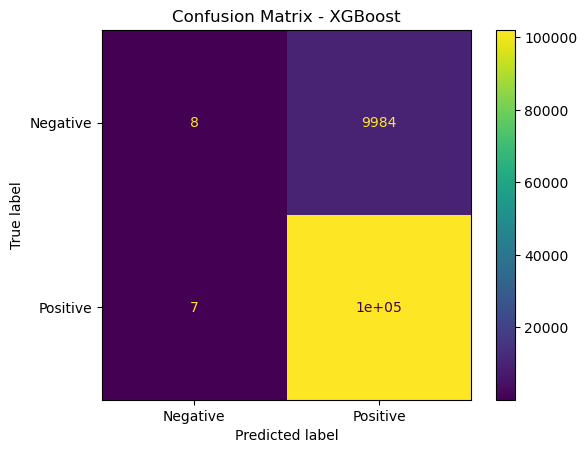

In [43]:
from xgboost import XGBClassifier

# Train-Test Split (make sure X and y are defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Model using XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,    # Number of boosting rounds
    max_depth=6,         # Maximum depth of a tree
    learning_rate=0.1,   # Step size shrinkage
    random_state=42,     # Reproducibility
    use_label_encoder=False,  # Avoid warning in recent versions of XGBoost
    eval_metric="logloss"     # Loss metric for binary classification
)

xgb_model.fit(X_train, y_train)

# Evaluate the Model
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Xgboost_Accuracy: {accuracy_xgb}")
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb, display_labels=["Negative", "Positive"])
disp_xgb.plot()
disp_xgb.ax_.set_title("Confusion Matrix - XGBoost")

In [36]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Train-Test Split (make sure X and y are defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize Naive Bayes
nb_model = GaussianNB()

# Train Naive Bayes Model
nb_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = nb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")


Accuracy: 0.640625


Decision Tree Accuracy: 0.9107053571428572


Text(0.5, 1.0, 'Confusion Matrix - Decision Tree')

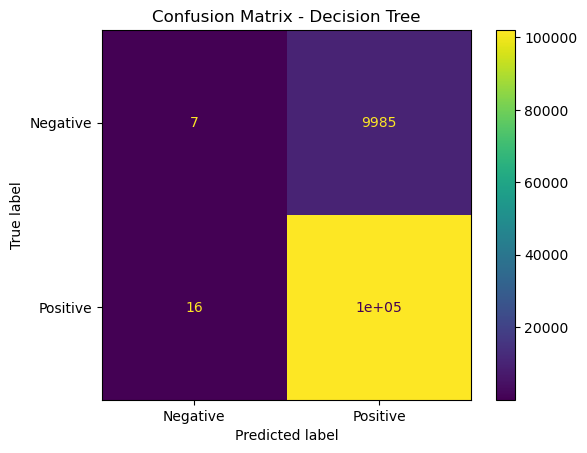

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# Train-Test Split (make sure X and y are defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Initialize Decision Tree
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)

# Train Decision Tree Model
dt_model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = dt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree Accuracy: {accuracy}")

y_pred_dt = dt_model.predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["Negative", "Positive"])
disp_dt.plot()
disp_dt.ax_.set_title("Confusion Matrix - Decision Tree")


Logistic Regression Accuracy: 0.9107857142857143


Text(0.5, 1.0, 'Confusion Matrix - Logistic Regression')

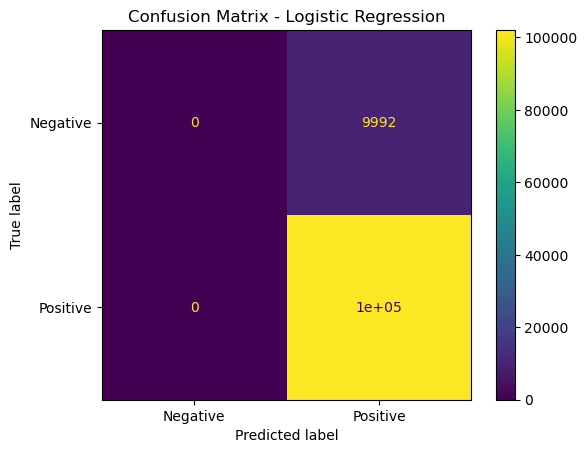

In [46]:
from sklearn.linear_model import LogisticRegression

# Train-Test Split (make sure X and y are defined)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model using Logistic Regression
logistic_model = LogisticRegression(max_iter=500, random_state=42)
logistic_model.fit(X_train, y_train)

# Evaluate the Model
y_pred = logistic_model.predict(X_test)
accuracy_lr = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Accuracy: {accuracy_lr}")

y_pred_lr = logistic_model.predict(X_test)
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["Negative", "Positive"])
disp_lr.plot()
disp_lr.ax_.set_title("Confusion Matrix - Logistic Regression")

In [23]:
# # Make Recommendations
# def recommend_similar_tracks(input_track_uri, track_features, model, df, top_n=10):
#     input_features = track_features.get(input_track_uri, np.zeros(101))
#     candidates = df['track_uri'].unique()

#     scores = []
#     for candidate in candidates:
#         candidate_features = track_features.get(candidate, np.zeros(101))
#         pair_features = np.concatenate([input_features, candidate_features])
#         score = model.predict_proba([pair_features])[0][1]
#         scores.append((candidate, score))

#     scores = sorted(scores, key=lambda x: x[1], reverse=True)[:top_n]
#     recommended_tracks = [df[df['track_uri'] == track]['track_name'].values[0] for track, _ in scores]
#     return recommended_tracks

# # Example usage
# input_track_uri = "spotify:track:1jNNHFZmRGXZFHlil5uhei"  # Replace with actual URI
# recommendations = recommend_similar_tracks(input_track_uri, track_features, model, df)
# print("Recommended Tracks:", recommendations)



| **Model**               | **Accuracy**  |
|--------------------------|---------------|
| Random Forest            | 91.06%       |
| XGBoost                  | 91.08%       |
| Logistic Regression      | 91.08%       |
| Decision Tree            | 91.07%       |

